# Graph Analysis Techniques without Feature Learning

# Classification with graphs

## Lab 1 : Standard/Linear SVM 

### Xavier Bresson


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/03_Traditional_GML/02_classification'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd

In [2]:
# Load libraries

# Math
import numpy as np

# Import data
import scipy.io

# Visualization 
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time

# Import functions in lib folder
import sys
sys.path.insert(0, 'lib/')

# Import helper functions
%load_ext autoreload
%autoreload 2
from lib.utils import compute_purity

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data matrix X = linearly separable data points
mat = scipy.io.loadmat('datasets/data_linearSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['Cgt_train'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()

40 2 2


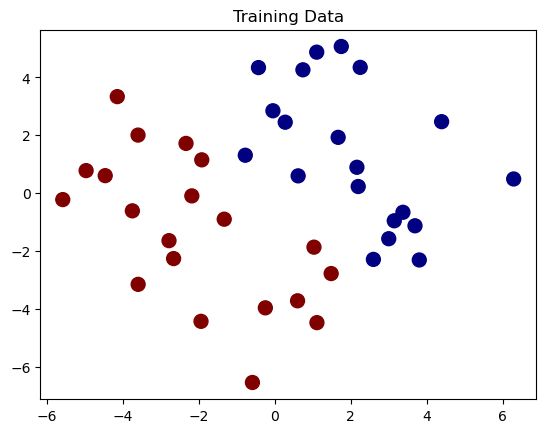

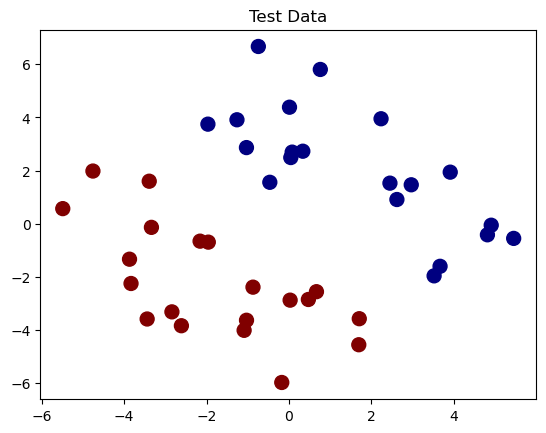

In [4]:
plt.figure(1)
size_vertex_plot = 100
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data')
plt.show()

plt.figure(2)
size_vertex_plot = 100
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
plt.show()

<Figure size 640x480 with 0 Axes>

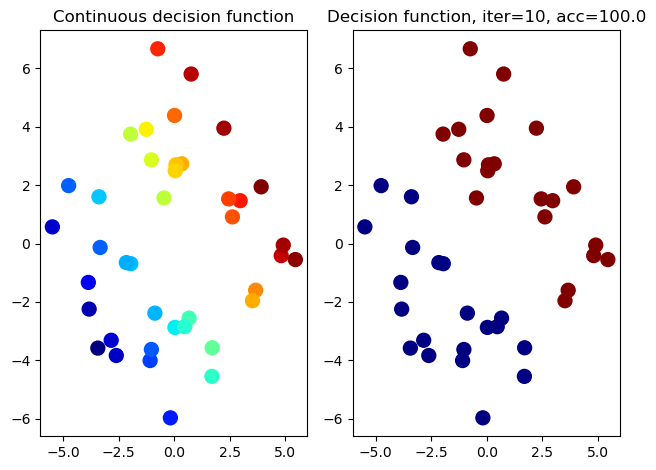

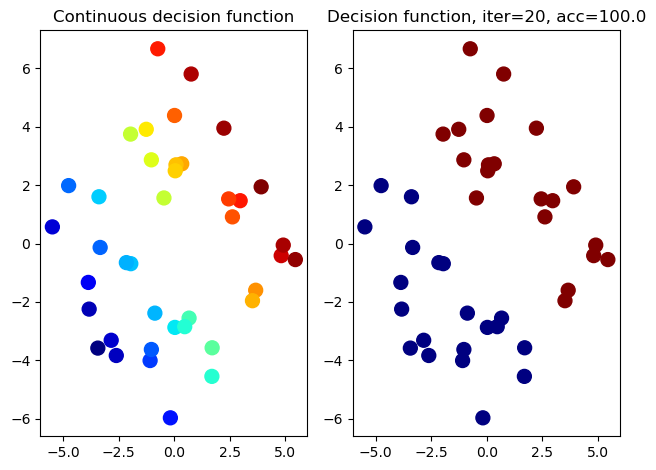

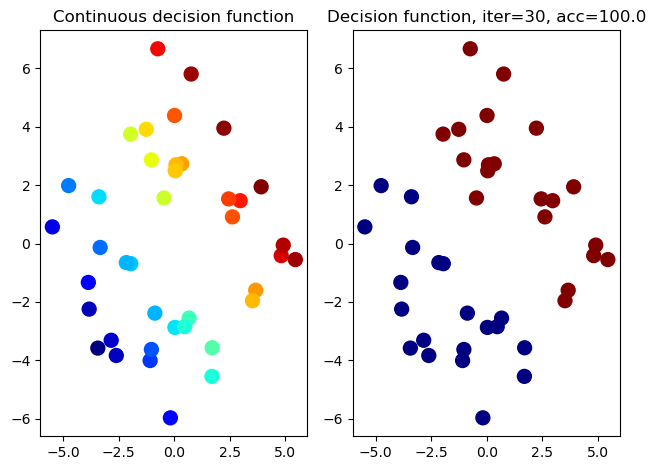

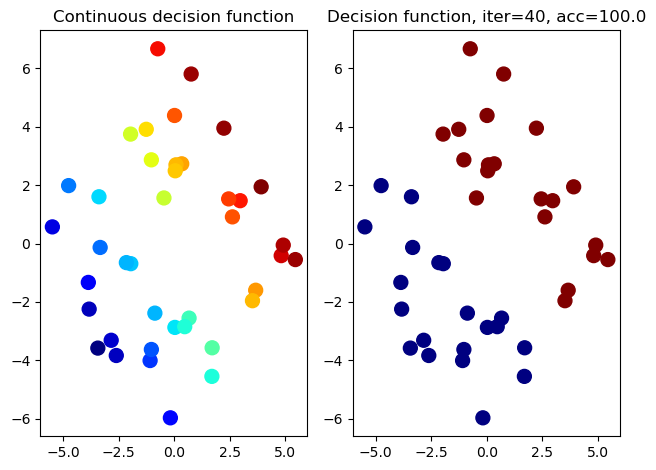

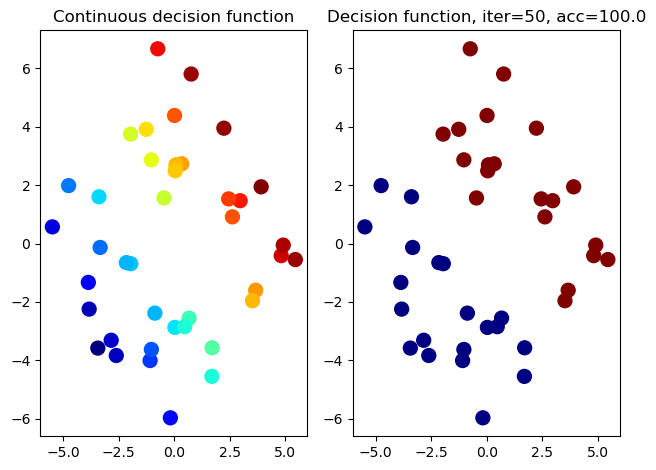

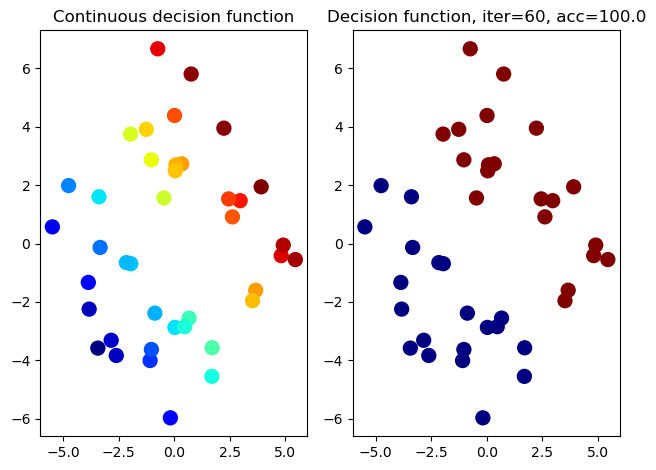

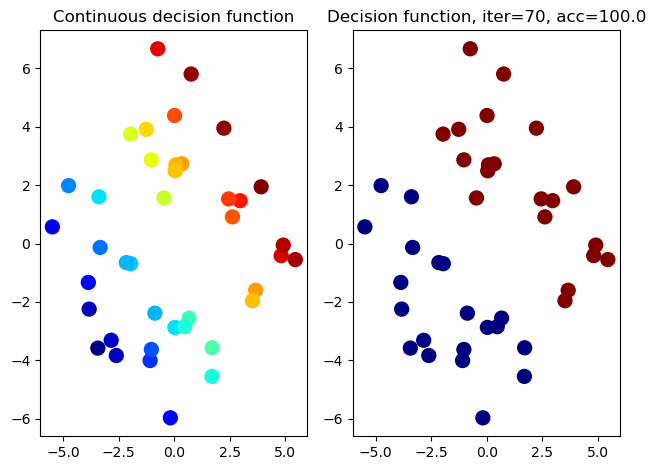

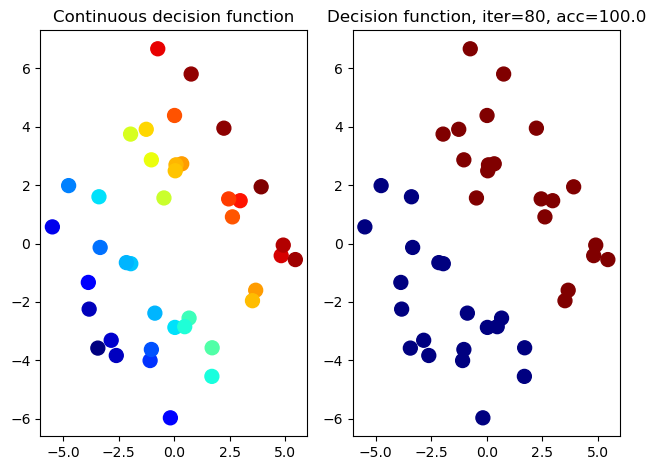

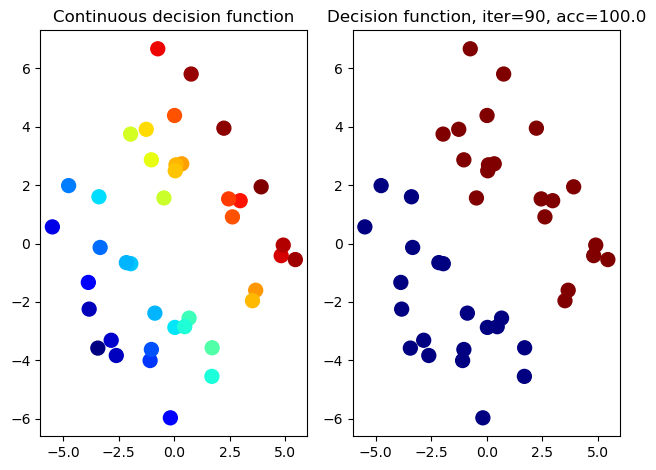

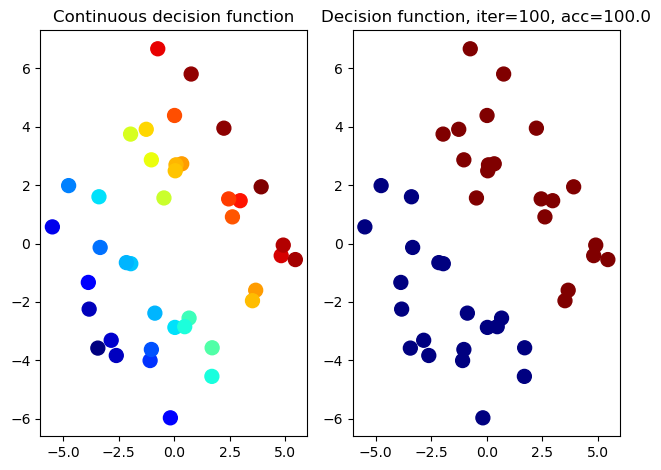

In [5]:
# Run Linear SVM

# Compute linear kernel, J, Q
Ker = Xtrain.dot(Xtrain.T)
L = np.diag(l_train)
l = l_train
Q = L.dot(Ker.dot(L))

# Time steps
sigma = 1./ np.linalg.norm(L,2)
tau = 1./ np.linalg.norm(Q,2)

# For conjuguate gradient
Acg = tau* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Initialization
x = np.zeros([n])
y = 0.0
xold = x

# Plot
fig = plt.figure(3)
fig.canvas.draw()
plt.show(block=False)

# Loop
k = 0
diffx = 1e6
while (diffx>1e-3) & (k<101):
    
    # Update iteration
    k += 1
    
    # Update x
    # Approximate solution with conjuguate gradient
    b = x + tau - tau* l* y
    x,_ = scipy.sparse.linalg.cg(Acg, b, x0=x, tol=1e-3, maxiter=50)   
    x[x<0.0] = 0 # Projection on [0,gamma]

    # Update y
    y = y + sigma* l.T.dot(x)
    
    # Stopping condition
    diffx = np.linalg.norm(x-xold)
    xold = x
    
    # Plot
    if not(k%10):
           
        # Lagrangian multipliers
        alpha = x
        
        # Indicator function of Support Vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( Ker.dot(L.dot(alpha)) - l )/ nb_sv
        else:
            b = 0
            
        # Continuous decision function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary decision function
        C_test = np.array( 1./2* ( 1+ np.sign(f_test) ) , dtype=np.int64) # decision function in {0,1}
        accuracy_test = compute_purity(C_test,Cgt_test,nc)

        # Plot
        #plt.figure(2)
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Continuous decision function')
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Decision function, iter=' + str(k) + ', acc=' + str(accuracy_test))
        plt.tight_layout()
        plt.show()
        fig.canvas.draw()
        time.sleep(0.1)
        